# Audio File Classification

#### Farhad Yousefi Razin - 310027                         
#### Mohamad Samaei - 314577

### STEP 1: Importing

In [6]:
import numpy as np
import pandas as pd
import wave
import matplotlib.pyplot as plt
import librosa
import keras
import scipy.io.wavfile as wav
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from scipy.io.wavfile import read
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from librosa import display
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.fftpack import fft
from scipy.signal import stft, istft
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

### STEP 2: Reading development csv file

In [7]:
development_df = pd.read_csv(r'C:/Users/user/Desktop/dsl_data/development.csv')

### STEP 3: Merging 'action' and 'object' label and creating new column called 'Predicted' which contains labels

In [8]:
development_df['Predicted'] = development_df['action'] + development_df['object']
development_df.drop(columns=['action'], inplace=True)
development_df.drop(columns=['object'], inplace=True)

In [9]:
development_df.head()

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Predicted
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,change languagenone
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,activatemusic
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,deactivatelights
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,increasevolume
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,advanced,English (United States),English (United States),female,22-40,increasevolume


### Step 4: Plotting some samples

#### 1. Finding out length of audio files

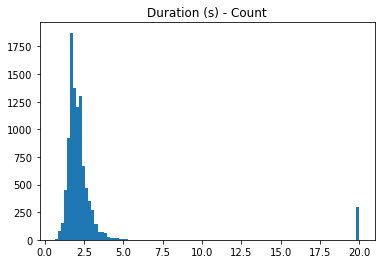

In [10]:
duration_list = []

desktop_address = "C:/Users/user/Desktop/"
for row in range(0, len(development_df.count(axis=1))):
    path = development_df.loc[row,'path']
    path_address = desktop_address + path

    wav_file = wave.open(path_address, 'r')

    #calculating duration of each .wav file
    num_frames = wav_file.getnframes()
    frame_rate = wav_file.getframerate()
    duration = num_frames / frame_rate
    duration_list.append(duration)

#plotting duration - count
plt.hist(duration_list, 100)
plt.title('Duration (s) - Count')
plt.show()

#### 2. Sample time - amplitude

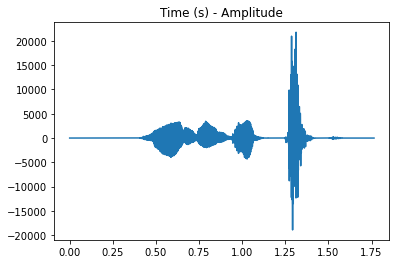

In [11]:
# load the audio data from the .wav file
fs, data = wav.read(desktop_address + development_df.loc[3,'path'])

# get the time values for each sample
time = np.arange(len(data)) / fs

# plot the time-amplitude representation
plt.plot(time, data)

# add labels to the axes
plt.title('Time (s) - Amplitude')

# show the plot
plt.show()

#### 3. Sample Frequency (Hz) - Magnitude "linear

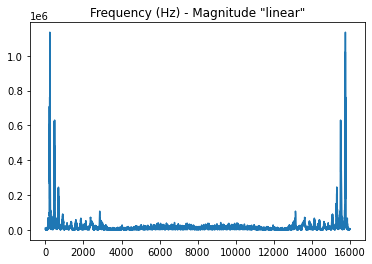

In [12]:
Fs, data = read(desktop_address + development_df.loc[1,'path'])

# Apply FFT
y = fft(data)

# Get the frequency axis in Hz
f = Fs * np.arange(len(y)) / len(y)

# Plot the frequency-magnitude in linear scale
plt.plot(f, np.abs(y))
plt.title('Frequency (Hz) - Magnitude "linear"')
plt.show()

#### 4. Sample Frequency (Hz) - Magnitude "dB"

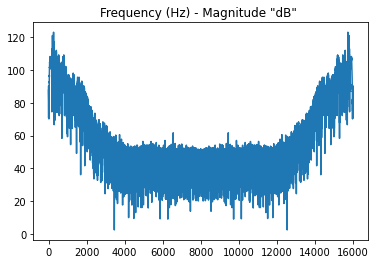

In [13]:
# Read the WAV file
Fs, data = read(desktop_address + development_df.loc[4,'path'])

# Apply FFT
y = fft(data)

# Get the frequency axis in Hz
f = Fs * np.arange(len(y)) / len(y)

# Convert the magnitude to dB
magnitude_dB = 20 * np.log10(np.abs(y))

# Plot the frequency-magnitude in dB scale
plt.plot(f, magnitude_dB)
plt.title('Frequency (Hz) - Magnitude "dB" ')
plt.show()

#### 5. Sample MFCC

C:\Users\user\AppData\Local\Temp\ipykernel_11736\152439523.py:3: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.9318040e-06
  3.8942535e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(y, sr=sr)


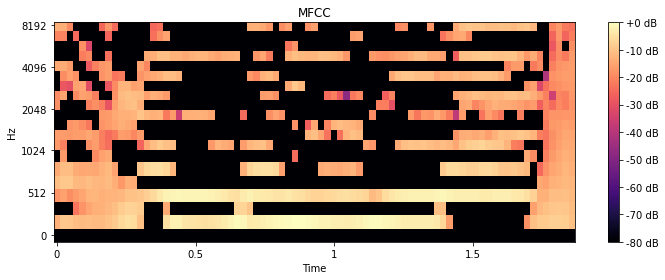

In [14]:
path = 'C:/Users/user/Desktop/dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-11e9-a9a5-5dbec3b8816a.wav'
y, sr = librosa.load(path)
mfcc = librosa.feature.mfcc(y, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mfcc, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

### STEP 5: This piece of code:
####    1. Loads audio file
####    2. Trims it (Removes low frequency parts)
####    3. Pads it (Length after padding is longer than the longest audio)
####    4. Creates its mfcc and appends to the 'mfcc_s' list

In [15]:
mfcc_s = []

for row in range(0, len(development_df.count(axis=1))):
    
    #Loading audio file
    path = development_df.loc[row,'path']
    path_address = desktop_address + path
    
    # Trim silence from the beginning and end of the audio file
    y, sr = librosa.load(path_address)
    yy, _ = librosa.effects.trim(y,top_db = 20)  
    
    #Padding
    p=235000-len(yy)
    padding=np.pad(yy,(0,p))
    
    #Creating mfcc for trimmed padded audio file
    mfcc = librosa.feature.mfcc(padding, sr=sr)
    #appending mfcc to the list
    mfcc_s.append(mfcc)

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.0869442e-03  6.9501519e-05  1.0575794e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00057187 0.00058051 0.00058863 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[3.1456380e-05 3.0807154e-05 2.8492566e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00396325 -0.00405649 -0.00404857 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.28989510e-05 -9.79020260e-05 -1.00690915e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[3.1425177e-05 2.5451100e-05 6.3994325e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.4244699e-06 -4.6887535e-06  9.8406588e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.686420e-06 -3.627952e-06  4.259816e-06 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 6.3110798e-07 -4.2755205e-06  6.5706804e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppDa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.7610425e-05 5.6742880e-05 5.9999526e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00033769 -0.00089804 -0.00135364 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00021736 -0.00017417 -0.00011057 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00162965  0.00194912  0.00301683 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00469971 -0.00485229 -0.00341797 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00528281 -0.00628854 -0.00105855 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0003914  0.00463362 0.00446977 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 8.253846e-05  5.295487e-05 -8.048513e-06 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00253643  0.00368088  0.00775733 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01813914 -0.01634589 -0.01495122 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0005277  -0.00175508 -0.00169264 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00162045 0.00199918 0.00170135 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.6663871e-05 2.6000766e-05 3.9591847e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.4230522e-04 2.0583603e-04 1.3488586e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.04463641 -0.00624859 -0.0476753  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\37

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00028144 0.00031079 0.00035559 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00061745 -0.00057745 -0.00044604 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00049488 0.00045581 0.00037397 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00531948  0.00031711 -0.00519781 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00987303 -0.01473884 -0.00796372 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.2955477e-04  9.4839481e-05 -3.1444115e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00268506  0.00131468  0.00501071 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.03835747 0.03403309 0.02725457 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00212776  0.00039239  0.0050328  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02655966 0.01873595 0.00877298 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00820637 -0.00426453 -0.00123479 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00011591 0.0001547  0.0001512  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00791872 0.00714829 0.00664166 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00064369 -0.00086537 -0.00097539 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00044783 -0.00063901 -0.00131512 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.8500895e-05 4.4421271e-05 6.3694875e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00657528 -0.00729455 -0.00377012 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00020159 -0.00028129 -0.00016894 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00896515 -0.00760294  0.00133102 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00233201  0.00012476 -0.00245628 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00466041 0.03179502 0.00611722 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[5.2248644e-05 5.8566337e-05 2.4297282e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.1285833e-04 -8.0870064e-05  9.1258487e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00113686 0.00248771 0.004056   ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.1095204e-04 -1.8202112e-04  7.9935249e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00422685 0.00946041 0.01464392 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.4579667e-04 -2.9707788e-05 -3.3948541e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00175306 0.00383887 0.00287265 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.05399055  0.03137147 -0.00947644 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0027771  0.00161743 0.00619507 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0002859  0.00085697 0.00102024 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01247607 -0.01279089 -0.01050098 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00044197  0.00833039  0.0048118  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00186893 0.00547189 0.00613803 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00033953 0.00050931 0.00051189 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0007464  -0.00044179 -0.00044151 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0014259   0.00361887  0.00785534 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0002492  -0.00011857 -0.00047412 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00094515 -0.00089915 -0.00078864 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.951763e-04  7.465145e-05 -3.286688e-04 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00018269 -0.0002389  -0.00028154 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.9300360e-05 -1.0365438e-04 -2.8883546e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00138256 -0.00152536 -0.00110709 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00045034 -0.00018912  0.00033272 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[5.562163e-04 2.487768e-04 4.264491e-05 ... 0.000000e+00 0.000000e+00
 0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarn

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00037761 -0.00083279 -0.0019839  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01557513  0.01687567 -0.002275   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00069257 -0.00764109 -0.00967011 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00112193 -0.0004647   0.00047376 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00185772 0.00217106 0.00153587 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00297382 0.00316543 0.0042356  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02077068  0.00718383  0.03685022 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01136252 0.00884171 0.00936801 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00025389 -0.00040464 -0.00020699 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01227052  0.06300004  0.04231643 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0219331   0.00801269 -0.01849967 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00159576 -0.00259943 -0.00257596 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00445963 -0.00625919 -0.01105537 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01848162 -0.00540929  0.01936116 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01108634 -0.02719253  0.00389342 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01608812  0.00166893 -0.01378866 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0001304   0.00073788  0.00096327 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01127099 -0.01823351 -0.01734529 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00329791  0.00870657 -0.00780273 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01109896 0.01081298 0.01015731 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.3991771e-04  5.7078007e-05 -5.0081831e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0016251  -0.00060962 -0.00034578 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00045313 -0.00052387 -0.00050612 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01625405 -0.00661292  0.04698757 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01243751 -0.01273113 -0.01322226 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.8325884e-05 6.7288282e-05 1.1640856e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00057731 -0.00058275 -0.00058448 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00080258 0.00073542 0.00072309 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.9556252e-04  3.4800833e-05 -3.4196698e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00016047 -0.00014506 -0.00017432 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00055622 -0.00090441 -0.00166101 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.1152078e-06 -2.9997666e-06  4.3471482e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00785968 -0.02221111 -0.02106208 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00541933 0.00035966 0.00552032 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00383825 0.01544034 0.02134243 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00669414 -0.01604334  0.01592221 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00018708 0.00021929 0.00024661 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00898979 0.01366832 0.02014585 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.6139410e-03 -5.9883176e-05  9.8542753e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02203896 0.02366974 0.02581286 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02198301 -0.01404223  0.0145032  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01528692 -0.0178373   0.01853874 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01557834 0.05283788 0.0531326  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00378223 -0.0001885  -0.01002584 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.3771340e-03  8.6598957e-05  1.5184242e-02 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.03969871 -0.04385468 -0.0103401  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01290798 -0.00677353  0.00771354 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00710195 -0.01149477  0.01035628 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00899829  0.00397721 -0.00844863 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01409334 -0.00860366 -0.00580373 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01774184 -0.00372923 -0.01268469 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00044379 0.00065444 0.00111664 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0003823  0.00099939 0.00136058 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00041332 -0.0014641  -0.00064335 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.0495339e-05 -2.5784266e-05 -3.1795968e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02371597  0.00154316  0.02739617 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00023306  0.0002746  -0.0001257  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 7.3272931e-05 -1.7982386e-05 -1.6446560e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.2482725e-04  3.1320989e-05 -2.4057052e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03316882 -0.01713722  0.00141298 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00030471 0.00092236 0.00035987 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0001463  0.00021317 0.00024206 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02041117 -0.01942031 -0.0126078  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00760881 0.01117024 0.01189297 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00045415 -0.00014371 -0.00063675 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03326352 -0.00180738  0.03035831 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.9658304e-05 -2.9642921e-05 -6.8856767e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01719552 0.04128491 0.05494527 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.6126925e-05 -8.3054721e-05 -9.8721299e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.004822e-04 8.143003e-05 9.710216e-05 ... 0.000000e+00 0.000000e+00
 0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00015987 0.00016652 0.0001373  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.540062e-04  6.587831e-05  8.141208e-04 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.8429549e-05 -4.8252125e-04 -4.5154750e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0009928  0.00132567 0.00151061 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00011555 -0.00152554 -0.00206994 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02441344  0.00215772 -0.00450659 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0002381  -0.00089461  0.00014875 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[9.2105314e-05 8.0456040e-05 4.5698716e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.6249199e-07  1.9459191e-07  1.7095898e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00091241 -0.00098709 -0.00089814 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00621298  0.00431166 -0.0001299  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.8695361e-05 -2.9253255e-05  8.8705192e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00012566 -0.00019895 -0.00018791 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00040937 0.00038477 0.0002006  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00247821 0.00281742 0.0013475  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00161439 -0.00167893 -0.00162272 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.0193857e-04 -7.0774506e-05 -1.6301058e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[4.9514092e-06 3.2698761e-05 5.7426038e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.7184444e-04 -1.0871742e-05 -2.3612860e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00748809 0.00805522 0.0071579  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02175385 -0.01677777 -0.04626497 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.1112078e-05 -1.4215881e-04 -1.5630751e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.9875399e-06  1.0306121e-05  1.2213734e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.759110e-05 9.390769e-05 6.804396e-05 ... 0.000000e+00 0.000000e+00
 0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00021496 -0.00010958 -0.00013849 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.7141652e-05 -1.3787019e-04 -2.3923641e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\37

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00032633 0.00112181 0.00118127 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01257644  0.00124802  0.01397611 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0001341  0.00016851 0.00022568 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.4226261e-04 -7.9228150e-05 -6.2870386e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.2445012e-05 -7.2255193e-06 -6.5617729e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01538302  0.00060333 -0.01456714 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00045903 -0.00037343 -0.00042289 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.06850219 -0.01828094  0.03209077 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0004513   0.00041269 -0.00018916 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00243711 -0.00623563 -0.00566029 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.9448018e-04 3.1575435e-04 7.4044074e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00043698 0.00050921 0.00052105 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00239281 0.00179922 0.00030262 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00081679  0.00015769  0.00217776 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00065613 -0.00041758 -0.00060363 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00035431 0.00037221 0.00036987 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00269445 -0.00354785 -0.00299085 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.005324    0.00197048 -0.00246826 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00577886 0.00962156 0.01130803 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00083862 0.00059097 0.00011755 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00545745 0.01221198 0.01811933 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01123608 -0.01322674 -0.01547582 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[4.9729232e-04 2.9782002e-04 5.6682689e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01156432 0.01318274 0.00365949 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00146041  0.00235966 -0.00208166 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00110513 0.00143826 0.00140652 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.5782311e-05 -1.5459079e-04 -7.0334063e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0647716   0.02829092 -0.03579836 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02883911 -0.009552    0.01608276 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.4177748e-07 -4.8965524e-07  1.2242605e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00044203 -0.00078958 -0.0009225  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00106812 -0.00064087  0.00057983 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01483571  0.01286402  0.02474647 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00079232 -0.00047965  0.00010338 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00118192  0.00810724  0.0103314  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.6905986e-05 3.2788310e-05 3.1142521e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.8858618e-05 -5.7568541e-05 -4.9682287e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.7187881e-06 -2.7805172e-06  2.1227572e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.5526483e-06 -2.5237756e-05 -3.0767846e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.02602449e-06  1.19475135e-05 -8.48585478e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02782437 0.03859221 0.03815274 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 6.6211749e-07  4.6756136e-06 -6.7733135e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00011568 0.000184   0.0001857  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00024417 0.0002795  0.00027699 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00051425 -0.00054994 -0.00057386 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00040897 -0.00038853 -0.00022919 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00610197  0.00110268  0.00379825 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01446635 -0.01515573 -0.01508653 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.0765483e-03 -3.0924370e-05 -4.7336338e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01798612 0.01855521 0.01910834 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0120281   0.0119322  -0.00612998 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00054849 -0.00037411  0.0005806  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.9092346e-04  5.8241953e-05  2.9615388e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.527092e-05 -6.975040e-05 -1.340434e-04 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00103939 -0.00221698 -0.0002558  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.3679628e-04 9.8985111e-05 3.3884779e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.6742847e-04 -8.3507344e-05  7.2413255e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0013388   0.00019389 -0.00061899 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01080808 -0.00750727  0.00216093 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00157611 -0.00235626  0.00715343 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.2186722e-05 2.8947613e-04 4.1936064e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00120373 -0.00124487 -0.00085066 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01079723 -0.00042099 -0.01585373 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00042488 -0.00054438 -0.00088754 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00310852 -0.02104314 -0.00778717 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00066038 0.0008932  0.00052807 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00179298 -0.00140807 -0.00098385 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01342954 -0.00484434 -0.01870125 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00381767 -0.00766074 -0.00333812 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00267099 -0.00083099  0.00219566 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00013998 0.00013616 0.00030512 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00071764 0.00063572 0.0003897  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00080186 -0.0009463  -0.00091655 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00378418 0.0122395  0.01720125 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00092537 -0.00093989 -0.00091458 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.7672202e-05 6.1934326e-05 6.2142128e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.07108819 -0.07786676 -0.05842002 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01506921  0.01710673 -0.01622812 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00148311 0.00178339 0.00193788 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.9131410e-06 -5.1671424e-07  9.3129017e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00070412 -0.00063243 -0.00064545 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00028617 -0.00078825 -0.00051489 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00096101 0.02365199 0.00341763 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01549251 0.0158767  0.0162522  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.4724038e-05 -2.4575097e-06 -1.9213981e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.9790883e-05 -8.0835816e-06  6.0848583e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.008466    0.00141245 -0.00302818 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00364627 -0.00663955 -0.00605549 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00144553 0.00772166 0.00674215 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00064253 0.0005781  0.00064225 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00533456  0.00040399  0.00469234 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00069156 -0.00305743 -0.00488524 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00712696 -0.0068714  -0.00669157 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01020494 -0.01935432 -0.00328389 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00259901 -0.00018865 -0.00232285 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.2763399e-04 6.7270768e-05 1.3956866e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0031072  -0.00304159 -0.00304502 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02368571 -0.01831611 -0.00970583 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.2205595e-05 -1.4237362e-04 -2.1723539e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.04926616 -0.02439777  0.01295237 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.7551552e-05 -6.3764346e-05 -6.4709064e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00102606 0.00095977 0.00060395 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00165079 0.00283391 0.00331994 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01373593 -0.0123733  -0.01008798 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00648207 0.00720073 0.0064163  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00015042 0.04682798 0.03471531 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00014158 -0.00015433 -0.00011496 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.2308377e-06 1.2844504e-06 3.4848632e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.0725531e-05 -2.9014132e-04 -5.7235971e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.4371320e-06 -2.1627661e-06 -1.4768193e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00994954 -0.01067909 -0.01129512 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01866458 -0.01061686  0.00747907 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00329114 -0.0082275  -0.00913548 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.1027710e-07  6.3208120e-07 -1.9256318e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00120351  0.00060645 -0.00069577 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[9.7554068e-05 4.5588677e-05 8.7750486e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00578116 -0.00255696  0.0046017  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00340563 -0.01516607 -0.00045485 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00674403 0.00799962 0.00578502 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0016898  -0.00136127 -0.00211095 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00015927 -0.00011209  0.00026653 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 8.799611e-04  8.452047e-05 -1.173847e-04 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00733815 -0.00379552  0.00818809 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00071458 0.00102754 0.00084506 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00696388 -0.0020591   0.00198015 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00381056  0.02069041  0.00965224 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00467894 0.00105435 0.00104422 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00017806 -0.0005888  -0.00052263 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00084885 0.00071837 0.00020652 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00126883  0.00228799  0.00506601 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00152335  0.00040634  0.00060024 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00025264  0.0015424   0.00179334 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01393952 0.02802437 0.02554537 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00862328  0.00766231 -0.00558892 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01991462 -0.02827173 -0.06018691 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02013106 0.02130663 0.02198888 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00248848  0.00031821 -0.00044451 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00192261 0.00146484 0.00189209 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02777035 -0.00957886 -0.01541309 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02760024 -0.00498848  0.03917834 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00233248  0.02408935 -0.00412332 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.2869704e-04 -3.8914030e-04  9.7649412e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00294191 0.00369936 0.00057385 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00465029 -0.00059891 -0.01129755 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00621133 0.0063261  0.00521434 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01716672 -0.01796068 -0.01853782 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00014466 -0.00032837 -0.00019747 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00495824  0.00146362  0.0060541  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00329999 0.01229792 0.00773099 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00883877 -0.00177006  0.0087545  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00092956 0.00079399 0.00095649 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01088329  0.00761109  0.02819372 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00018911 0.00015422 0.00010952 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.3813116e-04  8.7449676e-05 -2.1780441e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02624667 -0.02885619 -0.02935423 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00213082 -0.00242139 -0.00228877 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00756364  0.00706539  0.01296492 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.05393577 0.05409861 0.05545425 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[4.6251039e-03 2.3437215e-03 7.0123679e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00031913 -0.00022247 -0.00012829 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0087883  -0.00892494 -0.00616883 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00213456 -0.00172367 -0.00105273 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02066699 -0.02177577 -0.02170298 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01779189 0.02279183 0.02487143 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01937039 0.01709662 0.01449505 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00025115 -0.0003667  -0.00038709 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00949302 0.0091086  0.00843521 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00011576 -0.0002068  -0.00016888 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.8228621e-04  2.8328162e-05  1.5415835e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0039983  0.00352338 0.00359741 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00119375 -0.01158324 -0.00427533 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00056835 -0.00062549 -0.00051511 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00085835 0.00103951 0.00078252 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.0360172e-05 -4.4845315e-04 -2.7781306e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00012479  0.00022516  0.0004807  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.03340035e-05  2.27587116e-05 -2.13296207e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.7490276e-05 2.4210547e-04 1.4620573e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0051686  0.00366531 0.0025537  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[8.5219195e-05 7.8295569e-05 2.2848505e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.8915396e-05  9.5364412e-06  4.9453911e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02313232 -0.00750732 -0.01055908 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00322475 -0.00306496 -0.00214505 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00018997 -0.00044424 -0.00060017 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.04328772  0.00710657 -0.03260925 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01620173 0.03646895 0.0299186  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.1261351e-04 -1.4442210e-04 -7.1144314e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.9581482e-05 -2.9572984e-04 -2.4179227e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00225349  0.0003019  -0.00156842 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00012871 -0.00021321 -0.00013024 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00048372  0.000437    0.00060264 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00044871 -0.00048879 -0.00041565 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.4046359e-05  1.4353816e-05 -6.2711920e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0333613   0.00335181 -0.03123326 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03016831 -0.02390441 -0.00145153 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.872487e-05 -3.197045e-03 -4.656137e-03 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01099071 -0.00147403 -0.01478269 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00401337  0.00092894 -0.00736619 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.3906282e-05 -9.8871038e-05 -9.7344506e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00014764 0.00016942 0.00018088 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0002208  -0.00135398 -0.00252561 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00106649 0.00367096 0.00531822 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00542779 -0.00298554 -0.00186312 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00124309 -0.00915571 -0.02051692 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01223269 -0.0075129   0.00163729 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.6387645e-06 3.1221087e-05 1.5598762e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.7000674e-05  6.6966220e-07  8.3147301e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00036887 -0.00035681 -0.00036921 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00207777 -0.00210584 -0.00208388 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00066222 -0.00066947 -0.0006302  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00705245 0.00832752 0.00501279 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00642341 0.01085401 0.0094776  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00282346 0.00263947 0.00308533 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00345448 0.00331495 0.00150657 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0015389  -0.00108152 -0.00036216 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00175832 0.00188006 0.00134712 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0271927   0.0046236  -0.02156512 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.3698196e-07 2.6641448e-08 3.9071562e-08 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.9206620e-05 2.6281805e-05 3.0211750e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.1397873e-05 -5.2617743e-05 -9.9066719e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Loc

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.3957151e-06  2.0391526e-05  3.2714815e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00040163 0.0004023  0.00045694 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00064216 0.0019448  0.00321057 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00078536  0.02684008  0.02254567 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01122228 0.01785019 0.0177782  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02926121  0.00593607 -0.01364612 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0283457  -0.02577052 -0.02373347 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.9335509e-06 -2.1348988e-06 -2.3827035e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.9250274e-06 -2.7129803e-07  2.8641575e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.3308637e-04 1.2562158e-04 2.2651746e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01946925 -0.00520863  0.01462909 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01712785 -0.04672167 -0.02473755 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.5274376e-05 -8.7241133e-06 -3.1408395e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00682097 -0.00428997 -0.01071285 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0031274   0.00766192  0.00535662 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02587862 0.03422182 0.03089871 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00050266 0.01131726 0.01746615 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.05730388  0.0287217  -0.00374669 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00280394 -0.00368229 -0.00461251 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.2825129e-05 -3.8521099e-05 -3.6789417e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.07915024e-04 3.50597293e-05 2.59583635e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00164824  0.00212944 -0.0118905  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00164877  0.00360391  0.00328444 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.5324829e-05  3.6165911e-06 -5.0481176e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.04375229 -0.04216584 -0.0401163  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00400519 0.00403882 0.00410456 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.058980e-06 -6.078315e-06  1.671281e-07 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01175055 -0.01549556 -0.02119835 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.69291476e-05 -1.01605605e-04 -2.62817019e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00369232 -0.00391955 -0.00387619 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00040128 0.0009442  0.00184897 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00063167 0.0036481  0.00252489 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.7998649e-09 -5.0917213e-09  1.5768016e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00276406 -0.00158033 -0.00033794 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.2071943e-06  2.6750031e-06  2.0378985e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00029844 -0.00039415 -0.00047406 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.4255235e-08  1.9580493e-07 -1.4938934e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 7.9970545e-07 -2.3313337e-06  1.3910213e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.1803016e-06 -2.5310269e-06  6.5037434e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0005759  0.01452181 0.02465266 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00025523 -0.00019996 -0.00012823 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02261367 0.02175343 0.02087101 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.67930653e-05 1.03303304e-04 1.42871722e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00861394 0.00667497 0.01224652 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[5.8258833e-05 6.8416346e-05 5.2033676e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00337954 0.01619242 0.0244334  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00024066 -0.00024687 -0.00024455 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.3789177e-06  1.7115295e-06  1.2669362e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00108639 -0.00110611 -0.00110469 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00626002 -0.00739311 -0.00851583 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00970566  0.0028149  -0.02151974 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00013152 -0.000126   -0.00025611 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.5623591e-04 9.8798337e-05 6.8800364e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.0271578e-05 -4.0092382e-06 -4.8985628e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0130596  0.01430883 0.01329582 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02201014 -0.02183143 -0.02282221 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.0047827e-04 -7.8812656e-05 -5.6339464e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 9.8675094e-04  5.3070160e-04 -4.6716803e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00013982 0.00048401 0.00092645 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.1956747e-04 -1.0566409e-04 -3.7015321e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00010238 0.00033183 0.0004777  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.3556172e-05 7.9981587e-04 1.5776759e-03 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00566173 -0.00013318 -0.00508909 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01233212 0.00440183 0.00600692 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00151933 -0.00142801 -0.00257937 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00042445 -0.00018685 -0.00011946 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00088726 -0.00070513 -0.00062594 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00080617 0.00154745 0.0010584  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00120203 -0.00305773 -0.00339503 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00034346 -0.00040282 -0.00108775 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00567148 0.00434848 0.00440506 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00145819 -0.00409979 -0.00164369 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00644403 -0.00564954  0.00227829 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0090243  -0.00825449 -0.00777086 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.7314938e-05  2.8987628e-04  4.9487478e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.03286481 0.04255103 0.04242638 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00734743 0.01325285 0.01809725 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00179922 0.00168383 0.00157536 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00946951 0.00962453 0.00974893 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 6.8152185e-05  2.8232060e-05 -3.1087686e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0287866  -0.02783122 -0.02672104 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.616233e-05 -6.163238e-05 -5.584180e-05 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0001205  -0.00015954 -0.00017847 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02128942 0.02242362 0.02345542 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00025971 0.00034073 0.00100073 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.8912535e-06  1.1601516e-03 -2.2731544e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00026166 -0.00025012 -0.00021974 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00382744 -0.00391092 -0.00252417 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00574799  0.00123889 -0.0064441  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00262843 0.00249498 0.00218814 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00083498 -0.00228366 -0.00074365 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00027666  0.00040303 -0.00014686 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02685148  0.01705651 -0.01956687 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00144932 -0.00108024 -0.00145212 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00049846 -0.00046103 -0.00040985 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01857688  0.04214088  0.03452606 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02509123 0.0261436  0.02706455 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02701397 0.02698007 0.02690296 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00162337 0.01155707 0.00052445 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.9195526e-05 9.0224319e-05 4.4282864e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01453217 -0.00945436  0.01642042 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 8.5534094e-07 -1.6856854e-06  7.0672837e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01107788  0.0020752  -0.0112915  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00886411 -0.00037087 -0.00367823 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0073788  -0.00601628 -0.00043651 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00251832 -0.00286636 -0.00197566 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00497283 0.00296514 0.00062488 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00107566 0.00061557 0.00013373 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00132935 -0.00139869 -0.00086346 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00022387 -0.0002138  -0.00020609 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.2071999e-05 -2.5500293e-04 -3.9261827e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.0540374e-05  4.8339607e-06  3.4043078e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.1110148e-06  5.5107848e-06 -2.6356229e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.2522137e-05 -9.8345816e-05 -9.5601092e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00132306 -0.00123374 -0.00118227 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00503794 -0.00493741 -0.00519193 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00088414 -0.00119114 -0.00140629 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00068543 -0.00053881 -0.00043796 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00018311 0.0005188  0.00067139 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00145484 -0.00134107 -0.00132567 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00085485 -0.00025774  0.00010428 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00623618 0.00692794 0.00751029 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01016235 -0.01062012 -0.01049805 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00150821 -0.0013112  -0.00081288 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00079277 -0.00085435 -0.00046102 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00951369 0.00949531 0.00856686 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00582886 0.00576782 0.00558472 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.7099465e-04 -9.4018229e-05 -4.3558184e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00028298 0.00076854 0.00113534 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.6105492e-05  2.8755001e-05 -2.6160269e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00034936 -0.00019168 -0.00018529 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01187993 -0.0089841  -0.00365531 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00088281 0.00117681 0.00107475 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00103799 -0.00163066 -0.00219696 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0024069  0.00144929 0.00067632 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.03684231 0.01372346 0.00416547 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00248753 0.00151493 0.00060142 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.04495756 0.03909802 0.03427477 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00045135  0.00104934  0.00151284 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00024008 0.00032303 0.00043582 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.0247792e-03  4.6263340e-05 -1.2971861e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00137792 -0.00093381 -0.00094447 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.4009640e-05  1.3391335e-04  1.4418429e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00595452 -0.00495751 -0.00403151 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01367416 0.01220188 0.00882071 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00124012 0.00143561 0.00150724 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00021691 0.00052795 0.00040714 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00069458 -0.00044526 -0.00026469 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.0311230e-04 -1.2837684e-04 -9.4712377e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.9705532e-06 -3.2372557e-06  7.8435542e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.65020847e-05 6.73142422e-05 1.50735805e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.06678609 -0.04309001 -0.03866379 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00030287 -0.00051115 -0.00055396 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0014644 0.001424  0.0012948 ... 0.        0.        0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01428339 -0.05324731 -0.01216105 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.03454126 0.04772947 0.06506452 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.59

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00156585 -0.00139526 -0.00128809 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.4139164e-06 -1.4678812e-04 -9.1190595e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00012291 -0.00014634 -0.00014764 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00160757 -0.00149031 -0.00089312 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00589303  0.00067299 -0.0023458  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00040637 -0.0002966   0.00109663 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.000351   0.00030877 0.00032683 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00041953 0.00035507 0.00022822 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00081016 0.00074849 0.00066908 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.0998951e-05 -6.0571023e-05 -2.1885156e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00101035 -0.00106393 -0.00105216 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.0247636e-07 -3.6987302e-07  1.7171190e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[5.8700280e-05 4.0987783e-05 4.1729640e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00246908 -0.00256781 -0.00270172 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.8940496e-05 -1.1592800e-05  2.6979792e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00014655 0.00018845 0.00026813 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01305857 -0.0156245  -0.01769701 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01272096 0.012642   0.01247219 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01052509  0.00414379 -0.01792924 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01149608  0.00954417 -0.00173584 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00073747 0.0004381  0.00034439 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.8750055e-05  5.6212022e-05 -2.7504453e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00461508 -0.00334239 -0.00063384 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01525604 -0.00833563  0.01432776 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00090767  0.00065949  0.00161419 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00069569 -0.0008164  -0.0019797  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.4815902e-04 -1.2889432e-05 -7.4292977e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00291887  0.00151413 -0.00079728 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00342014 -0.00254205 -0.00759368 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[5.8512316e-05 2.3354766e-04 3.3849766e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 5.4073244e-05 -8.1034501e-05 -5.0299120e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00030116 0.00048001 0.00100675 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00077451 0.00194875 0.00234564 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00045776 -0.00033569 -0.00036621 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.1331893e-03 -6.7951489e-04  9.4041952e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00061239 -0.00068493 -0.00037585 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.04785364 -0.03633406 -0.01386714 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.03410139 0.05130193 0.0454743  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[9.5410956e-05 1.1345152e-04 1.5707673e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00948963 -0.00901992 -0.00411209 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00024313 -0.00040426 -0.00054493 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.0806229e-04 -3.7123194e-05  6.6266662e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02529934 -0.0111011   0.00298469 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00014516 -0.00036138 -0.00038936 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.5246506e-05 -6.4461485e-05 -8.6202912e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01481795  0.00688685 -0.00308623 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.559667e-05 -6.072854e-05 -8.384298e-05 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.9236460e-05  3.0184960e-06 -8.4604064e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01692807 -0.00571757 -0.02207812 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.04809989  0.00440486 -0.04567076 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03957356 -0.0243063  -0.03347262 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00031025 -0.00032132 -0.00032808 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00012101 0.00013565 0.00010174 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02039002 -0.0255702  -0.01268083 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0002939  0.00038426 0.00013365 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[4.8099344e-05 3.3657641e-05 5.6302128e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.6725326e-05 1.9498878e-04 3.0482575e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01329419 -0.00722187 -0.00727201 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01424139 -0.01018737 -0.0122444  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.4147842e-04 1.3765169e-04 8.0771562e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.8562906e-05 -5.6232730e-05 -7.4288691e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00042428 -0.00135219 -0.00210619 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.6062312e-04 8.8562068e-05 1.5863687e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0265933  -0.01174427 -0.03048988 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00811415 -0.00964037 -0.01169026 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00451522 0.00629097 0.00705605 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01148499 -0.0230071   0.02012966 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01136443  0.00275595  0.01212737 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.0220943e-04 -6.7498436e-04 -4.7513204e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.8021002e-08  1.7462478e-08  3.4309986e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02442187 -0.02456068 -0.02323653 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00387703 0.00173427 0.00087756 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00207138  0.00205822 -0.00868969 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00012509 -0.00021967 -0.00028316 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00032968 -0.00025519 -0.00020204 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.3065670e-05  8.9167352e-06 -1.3639938e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.4431094e-04 2.3062211e-04 7.4362528e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00078453  0.0009199   0.00189494 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.2271881e-06 -6.5894383e-05 -1.2867582e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00048877 -0.00018782 -0.00036908 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00628089 -0.02266138 -0.02881883 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00202177 -0.03843676 -0.07647716 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.9546857e-06 -6.8751302e-05 -4.8239883e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.1024960e-05 -3.3297089e-05 -4.9215658e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00043053  0.0002646  -0.00040997 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.2594177e-05  3.5629960e-06  8.5196625e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0005506  -0.00018535 -0.00044927 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.2641647e-05 -1.4827669e-05 -3.4310647e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00255686 0.00293599 0.00105965 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.09172624 0.05611223 0.0177984  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.6790701e-05 -1.6075681e-04 -3.8786198e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00272559 0.00225596 0.00181517 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00770868 -0.00753195 -0.00723487 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.4022919e-05 -3.4123452e-05 -3.1229349e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.518803e-04  3.142071e-05  7.111603e-05 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.0723877e-05 -5.3212480e-06  5.1348925e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppDa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.03578181  0.00940637 -0.00482371 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00013135 -0.00400834  0.00376633 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.1896627e-05 -2.7155120e-05 -3.2888653e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.5451327e-05 -2.5302663e-05 -7.7104423e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.2371138e-06  1.5880903e-05  4.8952235e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02336116 -0.00276628 -0.02019482 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00011085 -0.00011456 -0.00012851 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.7610846e-07 -4.1688125e-08 -9.6936450e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[7.5941862e-05 1.0327385e-04 8.9471454e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.7233277e-06 -8.8662237e-06  4.4354867e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.5494474e-05  5.5821201e-06  7.6777195e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.39743825e-05 -3.47669520e-05 -3.26560657e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\User

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00113191 -0.00108162 -0.00103841 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.1773121e-04 -1.4035100e-04  2.4558251e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.2627878e-05 -2.4749377e-05  6.0682769e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.3689814e-05 -2.6974452e-04 -2.3680020e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00034424 -0.00019623 -0.00044315 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02239073 0.03053785 0.00560219 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00088743 -0.00105134 -0.00032618 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 6.4512278e-06 -2.3052965e-07 -3.3308027e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0240394   0.00576228  0.04418668 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00653053 0.00645658 0.00238561 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00111457 -0.00158612 -0.00138142 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.131578e-05 -8.339273e-06  4.959332e-06 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Fut

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00195745  0.00015035 -0.00223442 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0016552  0.00099564 0.00028051 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00278818 -0.00653943 -0.01289528 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00085247 -0.00028573 -0.0009573  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00041686 -0.00108359 -0.00092157 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.2600283e-04  5.5466364e-05  3.4087693e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.4576204e-04 5.7621119e-06 2.1212429e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.9520367e-06 -4.3624996e-06  3.2283442e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01642534 -0.0169846  -0.02104971 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.2725775e-05 1.3272300e-04 1.1121207e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.6617470e-04  7.8103738e-05 -2.4321818e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03858148  0.03582633  0.05529991 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00154105  0.00176251 -0.00086073 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00011907  0.00025631  0.00036562 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.2396439e-04  2.3385470e-05 -5.4817683e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0002532  0.00043617 0.00056804 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00862587 -0.00631156 -0.00496933 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.08764318 -0.09200039 -0.09045562 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 5.5435288e-04  2.9036659e-05 -4.5555243e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00317697 0.00342616 0.00102813 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01498498 -0.0066443  -0.01295865 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.5138844e-04 1.3304433e-04 2.7540580e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0012812  0.00147441 0.00148573 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.5747838e-04 -2.8676164e-05  1.4749178e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00549379 0.00745495 0.00840483 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00021742 -0.00052369 -0.00057067 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0034217  0.00323963 0.00234442 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00066964 0.00019483 0.00023334 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0023207  0.00478678 0.00331345 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00516643 -0.00122271 -0.00339985 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00654962 0.01644164 0.01467491 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00389354 0.00360324 0.00199344 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00015123 -0.00029114 -0.00035687 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00076967 -0.00033744  0.00015828 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00029117 -0.00043123 -0.00026188 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[3.7533046e-05 3.4662150e-04 4.2198808e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0011709  -0.03742715 -0.04757495 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.03533536 0.03582028 0.03611649 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02180046  0.00224542  0.0268693  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00030417 -0.0002622  -0.00024716 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0002114  0.00023648 0.00025133 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00020949 0.00032406 0.00042077 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.04695269e-05 -4.34673966e-05  1.47124665e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00198549 -0.00378705 -0.00383826 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01833456 0.01835391 0.01848797 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\377885778

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00105854 -0.00348752 -0.00118229 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00600685 -0.01683726 -0.01765962 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00066993 -0.00057058 -0.00134206 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02333412 -0.02213821 -0.0210053  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.2469717e-05 -1.5019145e-04 -1.4468668e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00176817 -0.00433259 -0.00574988 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00033301 -0.00027365 -0.0004153  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00065993 0.000507   0.00040257 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00060851 -0.00107237 -0.0014444  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00777946 -0.00364656  0.01015753 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00485744 -0.00979668 -0.00029718 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02002931  0.00894541 -0.00307979 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00497135 0.00478525 0.00645016 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00011221  0.00122493  0.00088769 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00147724 0.00107958 0.0006688  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00013361 -0.00011318 -0.00012448 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-4.8856466e-05  6.3647883e-04  8.6353207e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00038038 -0.00211237 -0.00029596 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0030826  0.00287086 0.00184652 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.04829173 -0.06568573 -0.00542687 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00454978  0.00563299 -0.00455469 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.04033345 -0.00996087  0.03786097 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00683412 -0.00796243 -0.00941772 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00034624 0.00039488 0.00040097 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.2503058e-06 -3.0440397e-06 -6.4444001e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.2580231e-05 -8.9599365e-05 -9.0817470e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00671255 -0.00130418  0.00381435 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 8.4406856e-05  2.4220439e-05 -1.7768110e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.0368441e-05 -3.2576518e-05  4.0936171e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00033569 0.00057983 0.00033569 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 6.5072800e-06  9.6449712e-06 -4.2374337e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02471924 0.0199585  0.00708008 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.06855581 0.07499772 0.07616976 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00169198 0.00177716 0.00186626 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.4689334e-05 -5.0527004e-05 -7.6075579e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00087065  0.00771101  0.01006805 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00028597  0.00170434  0.00894487 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01798026 0.01555915 0.00460873 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01142277 0.01409979 0.01649241 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01320017 0.01304055 0.01205513 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 9.9545889e-07 -2.6947648e-06  8.9244378e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00323361 0.01007748 0.00927565 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00013221 0.00030634 0.00015402 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00412607 0.00579206 0.00318573 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01013975  0.01339718 -0.0156281  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0010901  -0.00397952  0.00174206 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00171977 -0.0017084  -0.00535729 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00081863 -0.00074101 -0.00087436 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00322546 -0.00498885 -0.00665248 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00015615 -0.00016134 -0.00017519 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00564768 -0.00571245 -0.00574242 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[5

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00093554 0.01483552 0.03071993 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00354683  0.00802386  0.00720897 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.4945212e-05 -1.1979709e-04 -2.7204037e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00610788 -0.00093343 -0.00919504 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02434434 -0.02655442 -0.02848192 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.2068685e-05  7.9733698e-05 -2.2744231e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.5566486e-06  5.9349618e-06 -1.2260535e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.978168e-05 -9.114711e-05 -4.717634e-05 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01686485 -0.00925799 -0.02211026 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.5111124e-06  6.4470300e-06  2.8312781e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.6648252e-05 6.4435233e-05 1.0163742e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01944005 0.04988799 0.01352548 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 3.8327417e-07  5.2334269e-07 -1.0619859e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.4006282e-04 -3.7701771e-05 -3.3535838e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.32142178e-04 -1.18672804e-04 -7.80173559e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\User

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.8936124e-06  1.8140869e-06  2.7760623e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0140172  -0.01301013 -0.01067183 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03320549 -0.00176865  0.02667244 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00090141 -0.00057137 -0.00013911 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00037122 -0.0005102  -0.00043329 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00018214 -0.00010294 -0.00010518 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[8

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00024176 0.00017706 0.0001146  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01478636 -0.01371151 -0.01295704 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00360548 -0.0038102  -0.00405732 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00010462 0.00014342 0.0001176  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 8.5921838e-06  7.1737295e-06 -2.0581943e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[9.1157141e-05 1.3657524e-04 2.2387019e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.2874707e-04  4.5030494e-04 -3.0039716e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.8396976e-06  1.7087996e-05  1.3901390e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00015313 0.0001132  0.00016948 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03907412 -0.0210142   0.00838387 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.06134189 -0.0114976   0.05049921 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 5.865749e-06 -8.121092e-06  9.700108e-06 ...  0.000000e+00  0.000000e+00
  0.000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00147806 -0.00650889 -0.00931394 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00528358 -0.00349222  0.00101302 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.8483772e-06 -1.8248702e-06  1.1891977e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00162962 -0.00148103 -0.00126166 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01725581 -0.01250017 -0.0365399  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00576462 0.00314114 0.00092931 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00161595 -0.00445199 -0.00770279 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00286231  0.00059175 -0.00173925 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00393179 0.00591236 0.00980565 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00211776 0.00392167 0.0015662  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.4501633e-05 -9.2197442e-04 -7.2401116e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01967174  0.05346829  0.03236164 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00113495  0.00059055 -0.00012197 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00302166  0.00366352  0.00824989 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00027429 0.0004234  0.00037503 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01430299 0.0155598  0.01655562 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.3595852e-06  1.2520244e-06  3.2058949e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.5275048e-10 -7.9402335e-10  7.7604659e-11 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00104907 -0.00114105 -0.00043451 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 5.5083524e-06 -2.3831130e-05 -7.2346833e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.8875164e-07 -1.7348104e-06  1.7697096e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0205105   0.00182996  0.0092213  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00844471 -0.01508134 -0.01995027 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 4.1485684e-08 -1.5935589e-08 -1.7086739e-08 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.7088480e-05 -3.6660011e-05  1.9721492e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.0333955e-06  5.6787121e-07 -3.3961735e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 7.4271979e-06 -3.3478545e-06 -5.9647405e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.0544897e-09 -2.3656705e-09  4.9836060e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01631614 0.01123304 0.02317148 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 2.6595447e-04 -2.0029447e-04  5.9341852e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.4723252e-07  1.3642696e-06 -1.3964752e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02486483 -0.01343875  0.03032224 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00100349 -0.00108045 -0.00093379 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0141127   0.01275011  0.02030769 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00488512 -0.00410409 -0.00314675 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00101906 -0.00026127 -0.00088331 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01085999 -0.00839472 -0.00501574 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00215641 0.00202272 0.00248557 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02050637 0.01802701 0.01153143 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00444767 0.00574592 0.0056191  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00274238 -0.00219541 -0.00154073 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00089979 -0.00107726 -0.00106111 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00121481 -0.00245747 -0.003494   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0010796  0.00036618 0.00140796 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00510289 -0.00992861 -0.01849633 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00490652 -0.00584326 -0.00704631 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01841074 0.01792222 0.01898091 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00491102 0.00590927 0.00776797 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00377202 -0.00678059 -0.00865469 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00670915 0.00794972 0.00799182 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00042062 0.00104037 0.00040495 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00043717 0.00036143 0.00028944 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01833029 0.01892843 0.01945871 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01237206 0.01861187 0.02182395 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00060671 0.00057551 0.00048062 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00211441 0.00215431 0.00220169 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00119446 -0.00111787 -0.00097161 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.7720909e-05 -6.8744252e-05 -1.1086862e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00240233 0.00326587 0.00323788 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0004815  0.00047495 0.00045481 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03515772 -0.00037244  0.04027028 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0005188  -0.00064087 -0.00079346 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.1317758e-04  5.3165413e-06 -6.9526934e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.8814240e-04 1.4039445e-04 9.9286211e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.06916188 -0.07282379 -0.07516535 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.04084585 -0.04213789 -0.04302403 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03489066 -0.03114061 -0.02411031 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00072417 -0.00658132 -0.00974019 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01052574 -0.00789268 -0.00382098 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0439911  0.06580973 0.04923163 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 7.4906161e-06 -4.5147285e-06 -3.8240680e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00014917 -0.0006535  -0.00086941 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[3.4868586e-05 2.4813475e-05 1.0953542e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03919228 -0.03929521 -0.04134236 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.03335571 -0.03271484 -0.03189087 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-7.5717779e-08  9.2665192e-07 -8.0993726e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0083993  -0.01651428 -0.00297844 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0001142  0.00043503 0.00069009 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.02059601 -0.00020097 -0.0006772  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01444761 -0.01521426 -0.007486   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01116943 0.0163269  0.01208496 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0471696  0.04695565 0.04660391 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00039649 0.00037595 0.00024324 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.037923   -0.03555836 -0.01948109 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0043671   0.02241677  0.03824798 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.01114566 -0.00051588 -0.01134763 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00465825  0.00164021 -0.00318995 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[4.6477355e-05 2.3144428e-04 1.6395087e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.5575838e-04 -2.4639798e-04 -6.7855653e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02344418 -0.02753545 -0.02848843 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00022053 -0.00053022 -0.00139528 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00087604  0.00083586  0.00069114 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00365951 0.00431055 0.00507685 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01035611 0.00908961 0.00778629 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.5351179e-05  2.7020223e-04  2.6438743e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 6.0274563e-04  7.4012278e-05 -1.4642183e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyke

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00541265 -0.006396   -0.00687886 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00451994 0.00531403 0.00623653 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00110436 -0.00076856 -0.00033536 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00591886 0.00646657 0.00681355 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-8.8336492e-05 -3.3455182e-04 -2.9644193e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00048537 -0.00036428 -0.00037223 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02210013 -0.02043799 -0.01415529 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00551757  0.00594047  0.01307416 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.6233725e-03 -1.1672555e-03  6.5743465e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00076235 -0.00127138 -0.00054617 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00021487  0.00033393 -0.00020476 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.0034283  -0.02101519 -0.02403094 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01858453 -0.01820351 -0.02047933 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00045169 -0.00165502 -0.00206011 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0018415  0.00297705 0.00232873 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00097656  0.          0.00088501 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[9.8909491e-05 1.5325930e-03 2.1433784e-03 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00021932 -0.0005027  -0.00338532 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: Futu

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0008386  -0.00069455  0.00042237 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00091179 -0.00109514 -0.00053588 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00091275 -0.00065623 -0.00032161 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00967407 0.00866699 0.00720215 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.02200317 0.02340698 0.01611328 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.1201927e-02 -2.4530485e-05 -7.0906729e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0004375  -0.0002775  -0.00017535 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00256347 -0.00212094 -0.00246754 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00074067 0.00227831 0.00241965 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00201809 -0.05402351 -0.05785044 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.6793548e-05  1.1127318e-03  5.7947251e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01764676 -0.00746569 -0.00976744 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0004167  0.00042397 0.00038484 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.5591521e-06 -7.5068216e-05 -1.5103623e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.5576855e-04 1.3901301e-04 5.2619780e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00113638 0.00118526 0.00127469 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00025239 -0.00028916 -0.00019491 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-6.6063556e-05 -9.8274060e-05 -5.4904860e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00231934 -0.00265503 -0.00094604 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.9516490e-06  3.1498528e-06 -1.0603766e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00176758 0.0029275  0.0035555  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00010817 0.00011893 0.00010829 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[7.1653741e-04 3.0816949e-04 4.7494985e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[2.3700434e-04 2.3093648e-04 6.8475441e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00055119  0.00038787 -0.00021806 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.8948713e-04  6.5930981e-05  3.8276741e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[1.05379841e-04 1.20811455e-04 8.38806809e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipyker

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-3.6184705e-05 -1.8335387e-04 -2.3955054e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-5.9374739e-05 -1.8937393e-05  6.0370312e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.2621656e-06 -1.3837998e-06  1.9019844e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 1.1330114e-03 -3.5574445e-05  4.4843706e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00017164  0.00026843  0.00015475 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0019658   0.00207034  0.00156066 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00152588 0.00198364 0.00140381 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00099119 -0.00114848 -0.00032804 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 7.5317766e-05 -3.1688254e-04 -2.5269587e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00027466  0.00192261  0.00183105 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00103754  0.00077679 -0.00118775 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00054457 -0.00370936 -0.00209442 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00096807 -0.00175542 -0.00137995 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0008935  -0.00035468  0.00069001 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-9.3870585e-05  6.7478511e-05 -5.5222714e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01959573 0.02554081 0.0187362  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.01392812 0.01712867 0.01074414 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00589354 -0.00544976 -0.00442349 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.01410712 -0.015344   -0.0144545  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0074963  -0.00773612 -0.00765465 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00017548 0.00030729 0.00035109 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00356202  0.00728957 -0.00068243 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0335636  0.02384952 0.01859584 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02547211 -0.04977397 -0.0309201  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00793092 -0.00211584 -0.00719429 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00277053  0.00721012  0.00548049 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-2.9983406e-04 -1.8269500e-04 -3.5605656e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00329974 -0.00078206 -0.00070274 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[6.9515139e-05 8.5704167e-05 1.2140356e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-1.5219400e-04 -1.2499085e-04 -2.2216640e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0455027  0.00704038 0.00081425 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00854492 -0.01287842 -0.01931763 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[ 0.00691463 -0.01525185 -0.0259959  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02656654 -0.02539702 -0.00900277 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00019249 -0.00017221 -0.00019148 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0004432  0.00057897 0.00069753 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00016854 0.00032462 0.00026047 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00078942  0.00521101  0.00459409 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00048117 -0.00033421 -0.00021811 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.0710572  -0.07294872 -0.07514615 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00370127 -0.00623686 -0.00245778 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02997308  0.00780051  0.01507003 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.00909131 0.00643404 0.00191394 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.00824443 -0.00627919 -0.00451382 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[0.0100586  0.01050061 0.01153993 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=

C:\Users\user\AppData\Local\Temp\ipykernel_11736\3778857782.py:18: FutureWarning: Pass y=[-0.02300861 -0.02216129 -0.02159499 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(padding, sr=sr)


In [16]:
# List to array
mfccs=np.array(mfcc_s)
mfccs = mfccs.reshape(mfccs.shape[0], -1)

### STEP 6: Oversampling

In [17]:
# define the oversampling strategy
ros = RandomOverSampler(random_state=40)

# separate features and target
y = development_df['Predicted']

# oversample the minority classes
X_resampled, y_resampled = ros.fit_resample(mfccs, y)

### STEP 7: Spiliting data to train and test

In [18]:
### Train Test Split
X_resampled_train,X_resampled_test,y_resampled_train,y_resampled_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=0)

### STEP 8: Standardization for development data

In [19]:
sc = StandardScaler()
X_resampled_train = sc.fit_transform(X_resampled_train)
X_resampled_test = sc.transform(X_resampled_test)

### STEP 8: Training with ANN (Approach 1)

In [15]:
# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit and transform the labels
development_encoded_labels = le.fit_transform(y_resampled_train)
development_encoded_labels = to_categorical(development_encoded_labels)

In [26]:
development_spectograms = np.array(X_resampled_train)

# Define the model
model = tf.keras.Sequential([
    
    #tf.keras.layers.Flatten(input_shape=(20, 195)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the development data
history = model.fit(development_spectograms, development_encoded_labels, epochs=100)

Epoch 1/100
458/458 [==============================] - 47s 101ms/step - loss: 1.2587 - accuracy: 0.5536
Epoch 2/100
458/458 [==============================] - 45s 98ms/step - loss: 0.7978 - accuracy: 0.7286
Epoch 3/100
458/458 [==============================] - 45s 97ms/step - loss: 1.0458 - accuracy: 0.8088
Epoch 4/100
458/458 [==============================] - 45s 98ms/step - loss: 0.6758 - accuracy: 0.8459
Epoch 5/100
458/458 [==============================] - 44s 96ms/step - loss: 0.3079 - accuracy: 0.9039
Epoch 6/100
458/458 [==============================] - 44s 96ms/step - loss: 0.2300 - accuracy: 0.9232
Epoch 7/100
458/458 [==============================] - 40s 87ms/step - loss: 0.1925 - accuracy: 0.9391
Epoch 8/100
458/458 [==============================] - 39s 86ms/step - loss: 0.1662 - accuracy: 0.9471
Epoch 9/100
458/458 [==============================] - 40s 87ms/step - loss: 0.1174 - accuracy: 0.9625
Epoch 10/100
458/458 [==============================] - 39s 86ms/step - 

### STEP 9: Testing ANN (on 20% of development data we splited)

In [27]:
# Fit and transform the labels
y_resampled_test_2 = le.fit_transform(y_resampled_test)

from keras.utils import to_categorical
y_resampled_test_2 = to_categorical(y_resampled_test_2)

# Evaluation of the model on the test data
test_loss, test_acc = model.evaluate(X_resampled_test, y_resampled_test_2)
print('Test accuracy:', test_acc)

115/115 [==============================] - 1s 7ms/step - loss: 1.3581 - accuracy: 0.9273
Test accuracy: 0.9273223876953125


### STEP 10: Testing ANN (on Evaluation data)

In [20]:
evaluation_df = pd.read_csv(r'C:/Users/user/Desktop/dsl_data/evaluation.csv')

In [21]:
mfcc_s_test = []

for row in range(0, len(evaluation_df.count(axis=1))):
    path = evaluation_df.loc[row,'path']
    path_address = desktop_address + path
    y, sr = librosa.load(path_address)
    yy, _ = librosa.effects.trim(y,top_db = 20)  # trim silence from the beginning and end of the audio file
    p=235000-len(yy)
    padding=np.pad(yy,(0,p))
    mfcc_test = librosa.feature.mfcc(padding, sr=sr)
    mfcc_s_test.append(mfcc_test)

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-9.9547375e-05 -9.7878707e-05 -6.1387138e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00758455  0.01610981  0.04742192 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.01128651 -0.01852172 -0.0135798  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00040334 0.00061694 0.00063317 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00614406 0.00618952 0.00466346 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00064435 0.00055552 0.00052953 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: Future

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.0114966  0.01110926 0.00620684 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00768584 0.0110124  0.00755044 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 5.5313041e-05  8.2254037e-06 -6.7003966e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[3.2718328e-04 3.0812784e-04 3.9985251e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00048734 -0.00039535 -0.00032726 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00867804 -0.00762318 -0.00148042 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.02079677  0.01220017  0.02067447 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00065087 0.00049313 0.00023615 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.04245824  0.00547871 -0.04572045 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 2.5404368e-02 -3.4973702e-05 -2.2607729e-02 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00212122 0.002169   0.00222386 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.02683187  0.0498438  -0.04936608 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00023432 -0.0037612  -0.00260803 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00392578 -0.00407369 -0.00421788 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.03244706 -0.01850379  0.00562921 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00117464 0.00094317 0.00095905 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[5.6968845e-04 2.5622750e-04 6.1417828e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0018056  -0.00149665 -0.00139369 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\152239

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00035792  0.00065918 -0.00038876 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.02614053 -0.00791379 -0.02602614 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00426502 0.0044109  0.00431099 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00024568 -0.00040425 -0.0004197  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-6.9355396e-05 -5.9378457e-05 -5.0756760e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00488625  0.00610881 -0.00021709 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00469266 -0.00457923 -0.00401524 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00062246 -0.00254618 -0.00230967 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 2.8795014e-06  7.5975812e-08 -3.9555562e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00125093 -0.00142857 -0.00047759 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-2.8223060e-06  2.0976365e-06  3.5441790e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00108697  0.00026462 -0.00164001 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00026379 -0.00035053 -0.00060697 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00392724 -0.0050202  -0.00511416 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 8.5623413e-03  1.6085647e-05 -1.0521989e-02 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00300736 -0.00305027 -0.00313591 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00610966  0.02286588 -0.00073864 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00986187 0.01101489 0.00616314 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-1.0186035e-04 -6.8490648e-05 -4.7938815e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.02418776 -0.02534109 -0.02584921 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00147288 -0.00134713 -0.00129698 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.01129365 -0.01344507 -0.00489638 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00081612 -0.00095707 -0.00045772 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00271367  0.01085499 -0.00042737 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0047993  -0.00359817 -0.00267474 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0012214  -0.00117481 -0.00115618 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00102829 -0.00057789  0.00124284 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00802578  0.05630269  0.01678413 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00161431 0.00466136 0.00277541 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-1.5774321e-04  4.5872966e-06  8.6596487e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00242561 0.00242548 0.00227975 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 2.9121324e-05 -5.4740212e-06  3.2891203e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0354797  -0.03620822 -0.03405521 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0013488  -0.00316156 -0.00100229 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00422685 -0.00453497 -0.00482047 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 8.3817853e-05  3.0967855e-04 -2.3696011e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00307469 0.00434296 0.01073951 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00196259  0.00172355 -0.00198217 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-3.2770430e-04 -6.6958099e-05  9.2602844e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00726005 -0.00827637 -0.00641281 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00034202 0.00041651 0.00043934 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00052707 -0.00049779 -0.00033554 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00036562 -0.00042396 -0.00015434 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00108662 0.00073679 0.00084871 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.0011936  -0.00049082 -0.0023193  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-8.8212233e-05  1.8273128e-04 -2.0099463e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-7.6036604e-06 -4.2347961e-06  3.0418667e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-1.15727225e-05 -4.74939225e-05 -5.89546617e-05 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding,

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00235055 0.00276578 0.00044546 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00301328 -0.0072378  -0.00357021 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 1.3661970e-04  1.6207236e-05 -9.1220965e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00767446 -0.00673673 -0.00424227 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-9.6118520e-06  2.1925371e-05 -4.1930998e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00115984 -0.00070811 -0.00038319 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00024104 -0.00029723 -0.000227   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00092261 -0.00390839 -0.00445468 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00145381 -0.00147686 -0.00097537 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00033785 -0.00023639 -0.00013709 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00344369 0.00257336 0.00247791 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.02389927 -0.06937027 -0.04343973 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0007474 -0.0007135 -0.0006497 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00024453 -0.0003507  -0.00035954 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00012854 -0.00069055 -0.00020237 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.01772839 -0.0172826  -0.01402178 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0011732  -0.00088668 -0.00072344 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.07031983 -0.01882315  0.01433969 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00598897 0.00888005 0.00992999 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00025814 0.00021483 0.00016929 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00919256 -0.00935042 -0.00944723 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureW

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-1.8765773e-04 -7.0544178e-05  2.4901648e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00123715 -0.00135299 -0.00127716 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.02757928 0.03273964 0.01944528 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.0185733   0.01187039 -0.01329677 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00113852 0.00189018 0.00215392 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00051764 -0.00283647 -0.00194719 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-1.8852268e-07  2.6408485e-03  5.2887271e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0004766   0.00222086  0.00177629 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00046402 -0.00080093 -0.00069813 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00160861  0.00054841 -0.000787   ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-8.9633315e-05 -6.4347420e-05 -2.6245003e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.01189352 -0.01046383 -0.0127738  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00306363 -0.00059182 -0.00016719 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-8.7461245e-05 -7.0365386e-05 -7.1995302e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.04255144 0.04257207 0.04238744 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00082861  0.00047818 -0.00167605 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00025567 -0.00068234 -0.00213165 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.01503135 -0.00589511  0.01150715 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00264423 -0.00243267 -0.0008759  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00127462 -0.0011782  -0.00115561 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 1.5227044e-04 -9.3409195e-05 -3.5307763e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00207759 -0.00144903 -0.00064439 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00353111 0.00749508 0.00491103 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.000771   -0.0016543  -0.00071559 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00102416 -0.00123458  0.00018823 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 5.3323827e-05 -6.9655420e-05 -1.1050803e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-7.6868482e-06 -1.9000892e-05  4.1010211e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Lo

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00085202 -0.00083686 -0.00073045 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00064633 -0.00076108 -0.00064275 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00123534 -0.00188881 -0.00229926 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWar

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00111352 -0.00114357 -0.00117322 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.0006354  -0.00071996 -0.00074374 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00039417 0.00042696 0.00041863 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00031866  0.00010147  0.00066494 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00090427 0.00101643 0.00095891 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00420115 -0.00165969  0.00013298 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00016028  0.00023249 -0.00010543 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.0137073  0.01562323 0.01725693 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00017283 0.00027914 0.00037189 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureW

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[3.8580329e-04 3.1274083e-04 9.0173897e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00022897 0.0004789  0.0004176  ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.0003035  0.00041019 0.00029365 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\15223

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00168544 0.00185065 0.00194484 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00014504 -0.00067782 -0.00058188 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00594769  0.00647958 -0.01243224 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00070399 -0.00068926 -0.00065115 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.0104929  0.0081793  0.00142773 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00815031  0.01011121  0.00850516 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 0.00027151 -0.00030597 -0.00037726 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00947524 0.03481431 0.02773411 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00094965 -0.00068219 -0.0005486  ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWa

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00187148 -0.00187571 -0.00158978 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.02006404 -0.00578508  0.00861097 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[ 4.2161971e-04  5.3625787e-04 -2.3925262e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[1.2765227e-04 1.6922630e-04 7.7905861e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-4.72905886e-05 -2.68295204e-04  1.20530574e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-3.5398793e-05 -1.2626442e-04 -1.3720484e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00112783 -0.00108948 -0.00111707 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-2.0783364e-06 -7.9641217e-07  2.3853568e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[0.00011281 0.00049896 0.00044685 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\

C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00367725  0.00107792  0.00663003 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-0.00186068 -0.00221921 -0.00240079 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)
C:\Users\user\AppData\Local\Temp\ipykernel_11736\1522391589.py:10: FutureWarning: Pass y=[-5.5695393e-05 -8.9302841e-05 -9.0767200e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_test = librosa.feature.mfcc(padding, sr=sr)


In [22]:
mfcc_s_test2 = np.array(mfcc_s_test)
mfcc_s_test2 = mfcc_s_test2.reshape(mfcc_s_test2.shape[0], -1)

In [23]:
mfcc_s_test2 = sc.transform(mfcc_s_test2)

In [33]:
# Make predictions on the test data
predictions = model.predict(mfcc_s_test2)

# Save the predictions in a new list
prediction_labels = []
for prediction in predictions:
    prediction_labels.append(np.argmax(prediction))

46/46 [==============================] - 0s 7ms/step


In [34]:
evaluation_labels = le.inverse_transform(prediction_labels)

In [35]:
# Create a new DataFrame with two columns
result_df = pd.DataFrame(columns=["Id", "Predicted"])

# Generate the "id" column
result_df["Id"] = range(0, 1455)

# Assign values from original_evaluation_labels to the "Predicted" column
result_df["Predicted"] = evaluation_labels

In [36]:
result_df

,Id,Predicted
0,0,increasevolume
1,1,increaseheat
2,2,decreaseheat
3,3,deactivatelights
4,4,decreasevolume
...,...,...
1450,1450,change languagenone
1451,1451,increasevolume
1452,1452,increaseheat
1453,1453,decreaseheat


In [37]:
result_df.to_csv(r'C:/Users/user/Desktop/Results/Results_ann.csv', index=False, sep=',')

### STEP 11: Training with Random Forest and KNN (Approach 2)

#### 10.1 merging development_df and evaluation_df (for similarity in label encoding)

In [60]:
approach2_df_development = development_df.drop('path', axis = 1)
approach2_df_development['mfcc'] = mfcc_s

approach2_df_evaluation = evaluation_df.drop('path', axis = 1)
approach2_df_evaluation['Predicted'] = 'Nothing'
approach2_df_evaluation['mfcc'] = mfcc_s_test

merged_df = pd.concat([approach2_df_development, approach2_df_evaluation])

#### 10.2 label encoding

In [61]:
le_2 = LabelEncoder()

# Fit the label encoder on the first DataFrame
merged_df['speakerId'] = le_2.fit_transform(merged_df['speakerId'])
merged_df['Self-reported fluency level '] = le_2.fit_transform(merged_df['Self-reported fluency level '])
merged_df['First Language spoken'] = le_2.fit_transform(merged_df['First Language spoken'])
merged_df['Current language used for work/school'] = le_2.fit_transform(merged_df['Current language used for work/school'])
merged_df['gender'] = le_2.fit_transform(merged_df['gender'])
merged_df['ageRange'] = le_2.fit_transform(merged_df['ageRange'])

In [62]:
merged_df.head()

,Id,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Predicted,mfcc
0,0,0,0,1,2,0,0,change languagenone,"[[-526.3765, -447.7765, -367.30096, -331.8413,..."
1,1,0,0,1,2,0,0,activatemusic,"[[-508.97012, -414.96906, -393.45593, -403.973..."
2,2,0,0,1,2,0,0,deactivatelights,"[[-693.09564, -616.1187, -582.1136, -589.5705,..."
3,3,0,0,1,2,0,0,increasevolume,"[[-428.62393, -393.03467, -371.4938, -350.3968..."
4,4,0,0,1,2,0,0,increasevolume,"[[-742.0755, -561.324, -503.49548, -508.84515,..."


#### 10.3 Splitting merged_df after encoding

In [63]:
approach2_df_development = merged_df[merged_df['Predicted'] != 'Nothing']

approach2_df_evaluation = merged_df[merged_df['Predicted'] == 'Nothing']
approach2_df_evaluation = approach2_df_evaluation.drop('Predicted', axis=1)

#### 10.4 oversampling development_df

In [64]:
X, y = ros.fit_resample(approach2_df_development.drop('Predicted', axis=1), approach2_df_development['Predicted'])
approach2_df_development_oversampled = pd.concat([pd.DataFrame(X, columns=approach2_df_development.drop('Predicted', axis=1).columns), pd.Series(y, name='Predicted')], axis=1)

#### 10.5 Standardizing development MFCCs'

In [65]:
mfcc_for_train = np.array(approach2_df_development_oversampled['mfcc'].tolist())
mfcc_for_train = np.array(mfcc_for_train)
mfcc_for_train = mfcc_for_train.reshape(mfcc_for_train.shape[0], -1)
mfcc_for_train = sc.fit_transform(mfcc_for_train)
mfcc_for_train = mfcc_for_train.reshape((18298, 20, 459))

#### 10.6 splitting standardized mfccs and calculating means and stds for each part

In [66]:
#Calculating mean for each submatrix and save all them in a list
def mean_of_submatrices(matrix):
  submatrices = []
  row_size = matrix.shape[0] // 10
  col_size = matrix.shape[1]
  for i in range(0, len(matrix), row_size):
    for j in range(0, len(matrix[i]), col_size):
      # Check if the submatrix should have fewer rows
      if i + row_size > len(matrix):
        row_size = len(matrix) - i
      # Check if the submatrix should have fewer columns
      if j + col_size > len(matrix[i]):
        col_size = len(matrix[i]) - j
      submatrix = np.array([matrix[x][j:j+col_size] for x in range(i, i+row_size)])
      submatrices.append(np.mean(submatrix))
  return submatrices

In [67]:
#Calculating Standard deviation for each submatrix and save all them in a list
def std_of_submatrices(matrix):
  submatrices = []
  row_size = matrix.shape[0] // 10
  col_size = matrix.shape[1]
  for i in range(0, len(matrix), row_size):
    for j in range(0, len(matrix[i]), col_size):
      # Check if the submatrix should have fewer rows
      if i + row_size > len(matrix):
        row_size = len(matrix) - i
      # Check if the submatrix should have fewer columns
      if j + col_size > len(matrix[i]):
        col_size = len(matrix[i]) - j
      submatrix = np.array([matrix[x][j:j+col_size] for x in range(i, i+row_size)])
      submatrices.append(np.std(submatrix))
  return submatrices

In [68]:
means = []
stds = []

for row in range(0, len(mfcc_for_train)):

    # save mean and standard deviation to list
    means.append(mean_of_submatrices(mfcc_for_train[row]))
    stds.append(std_of_submatrices(mfcc_for_train[row]))

In [69]:
transposed_means = [list(x) for x in zip(*means)]
for i, sublist in enumerate(transposed_means):
    approach2_df_development_oversampled[f'mean_{i+1}'] = sublist
    
transposed_stds = [list(x) for x in zip(*stds)]
for i, sublist in enumerate(transposed_stds):
    approach2_df_development_oversampled[f'std_{i+1}'] = sublist

In [70]:
approach2_df_development_oversampled = approach2_df_development_oversampled.drop('mfcc', axis=1)

In [71]:
approach2_df_development_oversampled.head()

,Id,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Predicted,mean_1,mean_2,...,std_1,std_2,std_3,std_4,std_5,std_6,std_7,std_8,std_9,std_10
0,0,0,0,1,2,0,0,change languagenone,-1.443419,0.034825,...,1.506729,0.457215,0.415161,0.278477,0.332680,0.227429,0.314708,0.420922,0.482775,0.415703
1,1,0,0,1,2,0,0,activatemusic,-1.638226,0.008020,...,1.593979,0.228963,0.211341,0.303461,0.222386,0.194186,0.230582,0.246465,0.279010,0.259508
2,2,0,0,1,2,0,0,deactivatelights,-2.170243,-0.029733,...,2.388566,0.498738,0.504877,0.459183,0.416168,0.325805,0.467533,0.418620,0.366586,0.372282
3,3,0,0,1,2,0,0,increasevolume,-1.091427,-0.044716,...,1.158186,0.331460,0.257318,0.315911,0.274532,0.217833,0.239400,0.330804,0.264527,0.353645
4,4,0,0,1,2,0,0,increasevolume,-1.759274,-0.005877,...,2.043898,0.494274,0.339368,0.266826,0.340960,0.231920,0.260599,0.355678,0.234701,0.288420


#### 10.7 Training with KNN

Accuracy when k is equal to 1: 95.60%


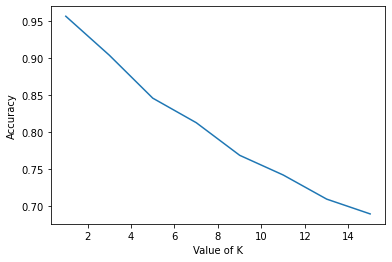

In [58]:
# Create the feature and target arrays
X = approach2_df_development_oversampled.drop('Predicted', axis=1)
y = approach2_df_development_oversampled['Predicted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the KNN Classifier
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
accuracies = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if k == 1: print("Accuracy when k is equal to 1: {:.2f}%".format(accuracy * 100))
    
plt.plot(k_values, accuracies)
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.show()

#### 10.8 Training with RandomForest

Accuracy when number of trees is equal to 90: 83.93%


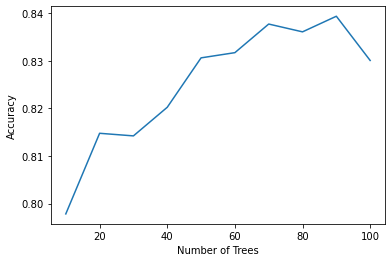

In [73]:
# Create the feature and target arrays
X = approach2_df_development_oversampled.drop('Predicted', axis=1)
y = approach2_df_development_oversampled['Predicted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier
tree_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracies = []

for trees in tree_values:
    clf = RandomForestClassifier(n_estimators=trees)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if trees == 90: print("Accuracy when number of trees is equal to 90: {:.2f}%".format(accuracy * 100))
    
plt.plot(tree_values, accuracies)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()


### STEP 12: Testing Random Forest (on Evaluation data)

In [74]:
mfcc_for_test = np.array(approach2_df_evaluation['mfcc'].tolist())
mfcc_for_test = np.array(mfcc_for_test)
mfcc_for_test = mfcc_for_test.reshape(mfcc_for_test.shape[0], -1)
mfcc_for_test = sc.fit_transform(mfcc_for_test)
mfcc_for_test = mfcc_for_test.reshape((1455, 20, 459))

In [75]:
means = []
stds = []

for row in range(0, len(mfcc_for_test)):

    # save mean and standard deviation to list
    means.append(mean_of_submatrices(mfcc_for_test[row]))
    stds.append(std_of_submatrices(mfcc_for_test[row]))

In [76]:
transposed_means = [list(x) for x in zip(*means)]
for i, sublist in enumerate(transposed_means):
    approach2_df_evaluation[f'mean_{i+1}'] = sublist
    
transposed_stds = [list(x) for x in zip(*stds)]
for i, sublist in enumerate(transposed_stds):
    approach2_df_evaluation[f'std_{i+1}'] = sublist
    
approach2_df_evaluation = approach2_df_evaluation.drop('mfcc', axis = 1)

In [77]:
y_pred = clf.predict(approach2_df_evaluation)

# Create a new DataFrame with two columns
result_df_randomforest = pd.DataFrame(columns=["Id", "Predicted"])

# Generate the "id" column
result_df_randomforest["Id"] = range(0, 1455)

# Assign values from original_evaluation_labels to the "Predicted" column
result_df_randomforest["Predicted"] = y_pred

In [78]:
result_df_randomforest.head()

,Id,Predicted
0,0,change languagenone
1,1,decreaseheat
2,2,decreasevolume
3,3,increasevolume
4,4,increasevolume


In [79]:
result_df_randomforest.to_csv("C:/Users/user/Desktop/Results/Results_randomforest.csv", sep=',', index=False)